<a href="https://colab.research.google.com/github/Hannah1011/llm-response-clustering/blob/main/Elo_Rating_0225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# 데이터 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/cluster_themes_ver4_km_192_11_0224_final.csv'
data = pd.read_csv(data_path)

In [27]:
# 초기 Elo 세팅
data['elo_old'] = 1000
data['elo_new'] = 1000
data['cluster_elo'] = 1000

In [28]:
data.head()

,coach_no,name,quality,created_at,query,answer,combined,guide_index,reason,reason_detail,n_tokens,cluster,cluster_avg_quality,theme_of_cluster,elo_old,elo_new,cluster_elo
0,NaN,NaN,-1,2024-12-05 13:57:09,식사 순서 바꾸기,식사 순서를 바꾸는 것은 건강한 식습관을 형성하는 데 도움이 될 수 있어요. 예를 ...,Query: 식사 순서 바꾸기; Answer: 식사 순서를 바꾸는 것은 건강한 식습...,"['34', '49', '45', '42', '35', '36', '41', '32...",NaN,NaN,396,9,0.292,간헐적 단식 후 첫 끼 식단 구성과 혈당 관리 방법,1000,1000,1000
1,NaN,NaN,1,2024-12-05 14:04:59,식초 희석량,식초를 희석하여 섭취할 때는 물 200mL 이상에 식초를 섞어 드시는 것이 좋습니다...,Query: 식초 희석량; Answer: 식초를 희석하여 섭취할 때는 물 200mL...,"['59', '67', '61', '62', '57', '65', '60', '58...",NaN,NaN,421,5,0.172,식초 활용과 섭취 방법 가이드,1000,1000,1000
2,NaN,NaN,1,2024-12-05 20:08:26,단식후 신경 안쓰고 먹었는데 신경써야하는게 있나요?,단식 후에는 식사에 신경을 쓰는 것이 중요합니다. 단식 후 무분별하게 음식을 섭취하...,Query: 단식후 신경 안쓰고 먹었는데 신경써야하는게 있나요?; Answer: 단...,"['112', '120', '122', '54', '242', '106', '117...",NaN,NaN,390,1,0.170,간헐적 단식 중 포만감 유지와 식품 선택 가이드,1000,1000,1000
3,NaN,NaN,1,2024-12-06 11:53:34,식이섬유가 많이 들어간 국물을 추천해줘,식이섬유가 많이 들어간 국물 요리를 추천드릴게요. 미역국은 식이섬유가 풍부한 해조류...,Query: 식이섬유가 많이 들어간 국물을 추천해줘; Answer: 식이섬유가 많이...,"['15', '167', '53', '28', '27', '75', '247', '...",NaN,NaN,444,10,0.253,식품 선택과 건강한 대체 식단 가이드,1000,1000,1000
4,NaN,NaN,1,2024-12-06 13:08:55,"나가사키짬뽕,유린기,고추잡채,과일사라다를 먹고 혈당스파이크가 발생한 이유를 말해줘\...","혈당 스파이크는 식사 후 혈당이 급격히 상승했다가 떨어지는 현상으로, 나가사키짬뽕,...","Query: 나가사키짬뽕,유린기,고추잡채,과일사라다를 먹고 혈당스파이크가 발생한 이...","['10', '185', '184', '153', '148', '26', '250'...",NaN,NaN,534,4,0.547,저혈당 및 혈당 스파이크 예방과 식단 조절 가이드,1000,1000,1000


In [29]:
# Elo 계산 함수
def calculate_expected(R_self, R_cluster, scale = 600):
  return 1 / ( 1+ 10 ** ((R_cluster - R_self)/scale))

def update_elo(R_old, expected, actual, K = 16):
  R_new = R_old + K * (actual - expected)
  return R_new

In [12]:
# 클러스터별 Elo 평균 저장
cluster_avg = data.groupby('cluster')['elo_old'].mean().to_dict()

# Elo 업데이트
for idx, row in data.iterrows():
  R_self = row['elo_old']
  R_cluster = cluster_avg[row['cluster']] # 클러스터 평균 Elo

  # 예상 승률 E
  expected = calculate_expected(R_self, R_cluster)

  # 실제 결과 S (quality 사용)
  actual = row['quality']

  # 업데이트 Elo 계산
  R_new = update_elo(R_self, expected, actual)

  # 데이터 저장
  data.at[idx, 'elo_new'] = R_new

In [13]:
# 클러스터별 평균 Elo 재계산
cluster_avg_updated = data.groupby('cluster')['elo_new'].mean().to_dict()
data['cluster_elo'] = data['cluster'].map(cluster_avg_updated)

In [14]:
# 파일로 저장
output_path = './humanfeedback_elo_updated.csv'
data.to_csv(output_path, index = False)
print(f"🍀저장 완료 : {output_path}")

🍀저장 완료 : ./humanfeedback_elo_updated.csv


In [15]:
# 클러스터별 Elo 시각화

# 클러스터별 Elo 전 / 후 비교용 데이터프레임 생성
cluster_change = data.groupby('cluster').agg(
    elo_old_mean = ('elo_old', 'mean'),
    elo_new_mean = ('elo_new', 'mean')
).reset_index()

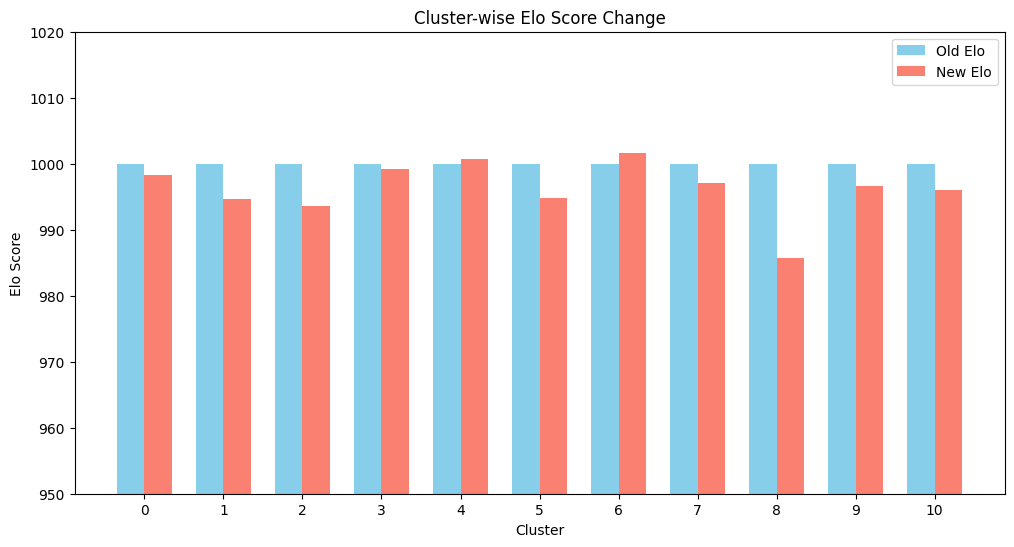

In [18]:
# 막대 그래프 시각화
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(cluster_change['cluster']))

plt.bar(x - bar_width/2, cluster_change['elo_old_mean'], bar_width, label='Old Elo', color='skyblue')
plt.bar(x + bar_width/2, cluster_change['elo_new_mean'], bar_width, label='New Elo', color='salmon')

plt.xlabel('Cluster')
plt.ylabel('Elo Score')
plt.title('Cluster-wise Elo Score Change')
plt.legend()
plt.xticks(ticks=x, labels=cluster_change['cluster'])

# ✅ Y축 범위 조정
plt.ylim(950, 1020)

plt.show()

<ipython-input-25-6aba04f03c4d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='elo_delta', data=cluster_change, palette='coolwarm')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128064 (\N{EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


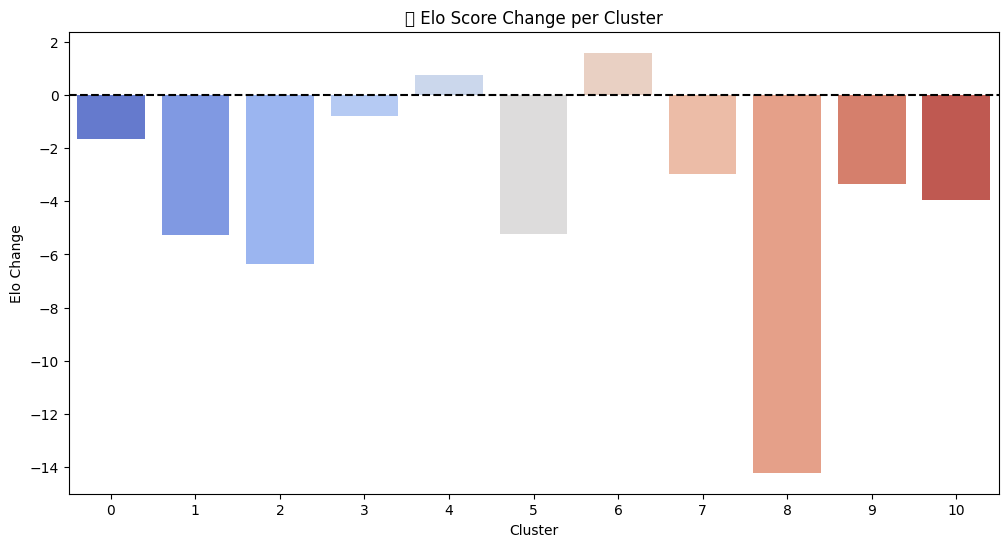

In [25]:
# 변화량 계산
cluster_change['elo_delta'] = cluster_change['elo_new_mean'] - cluster_change['elo_old_mean']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='elo_delta', data=cluster_change, palette='coolwarm')
plt.axhline(0, color='black', linestyle='--')
plt.title('👀 Elo Score Change per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Elo Change')
plt.show()


In [17]:
# 품질 저하 클러스터 알림 시스템


# 임계값 설정
threshold = 950

# 품질 저하 클러스터 탐색
low_quality_clusters = cluster_change[cluster_change['elo_new_mean'] < threshold]

if not low_quality_clusters.empty:
    print("⚠️ 품질 저하 클러스터 발견:")
    for idx, row in low_quality_clusters.iterrows():
        print(f" - 클러스터 {row['cluster']}: Elo {row['elo_new_mean']:.2f}")
else:
    print("✅ 모든 클러스터 품질 양호")

✅ 모든 클러스터 품질 양호
